In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from fastai.conv_learner import *
from fasterai.images import *
from fasterai.dataset import *
from fasterai.visualize import *
from pathlib import Path
from itertools import repeat
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True

/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jason/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
DATA_PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
TRAIN_SOURCE_PATH = DATA_PATH/'train'
uid = 'bw2color'
sz = 128
bs = 256
keep_pct = 0.02
TRAIN_X_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=True, size=sz, uid=uid)
TRAIN_Y_PATH = generate_image_preprocess_path(TRAIN_SOURCE_PATH, is_x=False, size=sz, uid=uid)
x_paths, y_paths = get_matched_xy_file_lists(TRAIN_X_PATH, TRAIN_Y_PATH)
x_paths_str = convert_paths_to_str(x_paths)
y_paths_str = convert_paths_to_str(y_paths)

In [4]:
print(x_paths_str[:5])
print(y_paths_str[:5])

['train_x_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_x_bw2color_128/n01440764/n01440764_10042.JPEG']
['train_y_bw2color_128/n01440764/n01440764_10026.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10027.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10029.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10040.JPEG', 'train_y_bw2color_128/n01440764/n01440764_10042.JPEG']


In [5]:
np.random.seed(42)
keeps = np.random.rand(len(x_paths_str)) < keep_pct
fnames_x = np.array(x_paths_str, copy=False)[keeps]
fnames_y = np.array(y_paths_str, copy=False)[keeps]

In [6]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]
val_idxs = get_cv_idxs(len(fnames_x), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames_x), np.array(fnames_y))
img_fn = TRAIN_Y_PATH/'n01558993'/'n01558993_9684.JPEG'
tfms = tfms_from_model(vgg16, sz, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_Y_PATH.parent)
md = ImageData(DATA_PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.val_ds.denorm

In [7]:
def generate_denormed_image_pairs(ds: FilesDataset, batches: [(ndarray,ndarray)], idx:int = 0):
    return [(ds.denorm(x)[idx], ds.denorm(y)[idx])for (x,y) in batches]

In [8]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

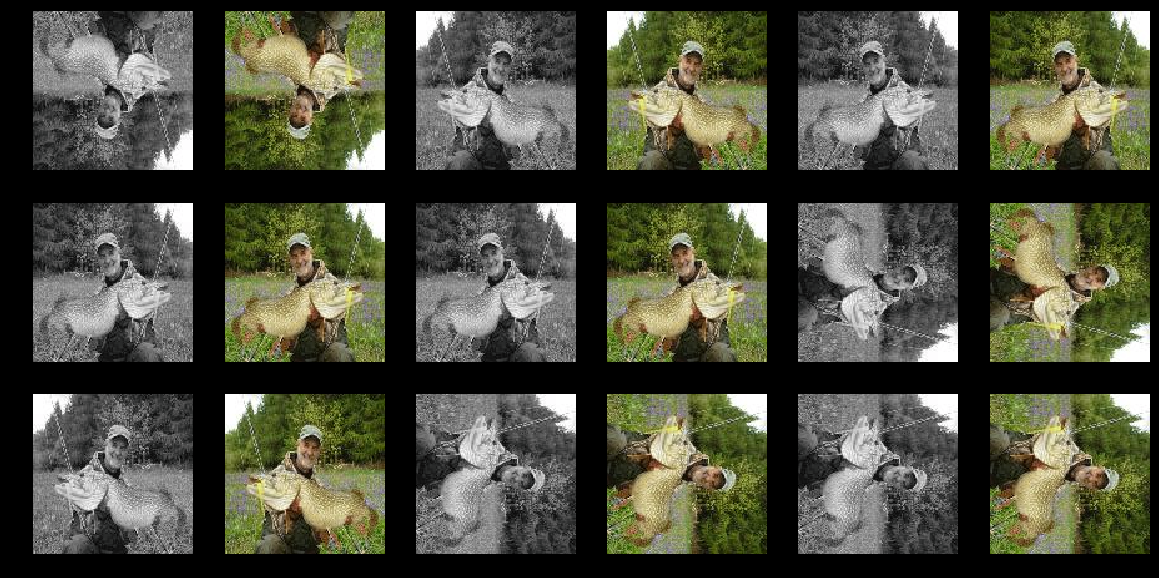

In [9]:
image_pairs = generate_denormed_image_pairs(md.val_ds, batches)
plot_images_from_ndarray_pairs(image_pairs, figsize=(20,10))

## Model

##### TODO:  Try using unet instead of SrResnet- also suspect that using pretrained model as base will work much better.
##### TODO:  After making unet version- plug that into a Weiserman GAN setup (the discrimator looks at grey image and colorized image, concatenated together via channels).

In [10]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [11]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): 
        return x + self.m(x) * self.res_scale

In [12]:
def res_block(nf):
    return ResSequential([conv(nf, nf, actn=True), conv(nf, nf)], 0.1)

In [13]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [14]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64, 64, scale),
                     nn.BatchNorm2d(64),
                     conv(64, 3)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): 
        return self.features(x)

## Training

In [15]:
m = SrResnet(64, 1)
m = to_gpu(m)
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)
m = nn.DataParallel(m, [0,1,2,3])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)
learn.set_data(md)
learn.crit = F.mse_loss #(turns sepia)
wd=1e-7

In [23]:
def train(lrs, session_num: int):
    if session_num > 0:
        learn.load(uid + str(session_num - 1))
    learn.fit(lrs, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))
    learn.save(uid + str(session_num))

In [32]:
def visualize(start_idx: int, count: int):
    end_index = start_idx + count
    plot_image_outputs_from_model(md.val_ds, learn.model, list(range(start_idx,end_index)), figsize=(20,20), max_columns=4)

In [18]:
learn.lr_find(1e-4, 0.1, wds=wd, linear=False)

 83%|████████▎ | 75/90 [01:28<00:17,  1.18s/it, loss=0.345]

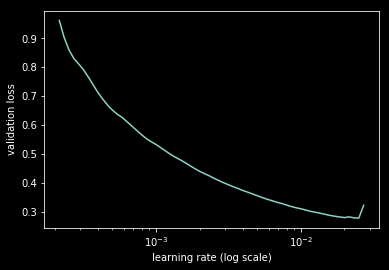

In [20]:
learn.sched.plot(n_skip_end=0)

In [21]:
lr=7e-3

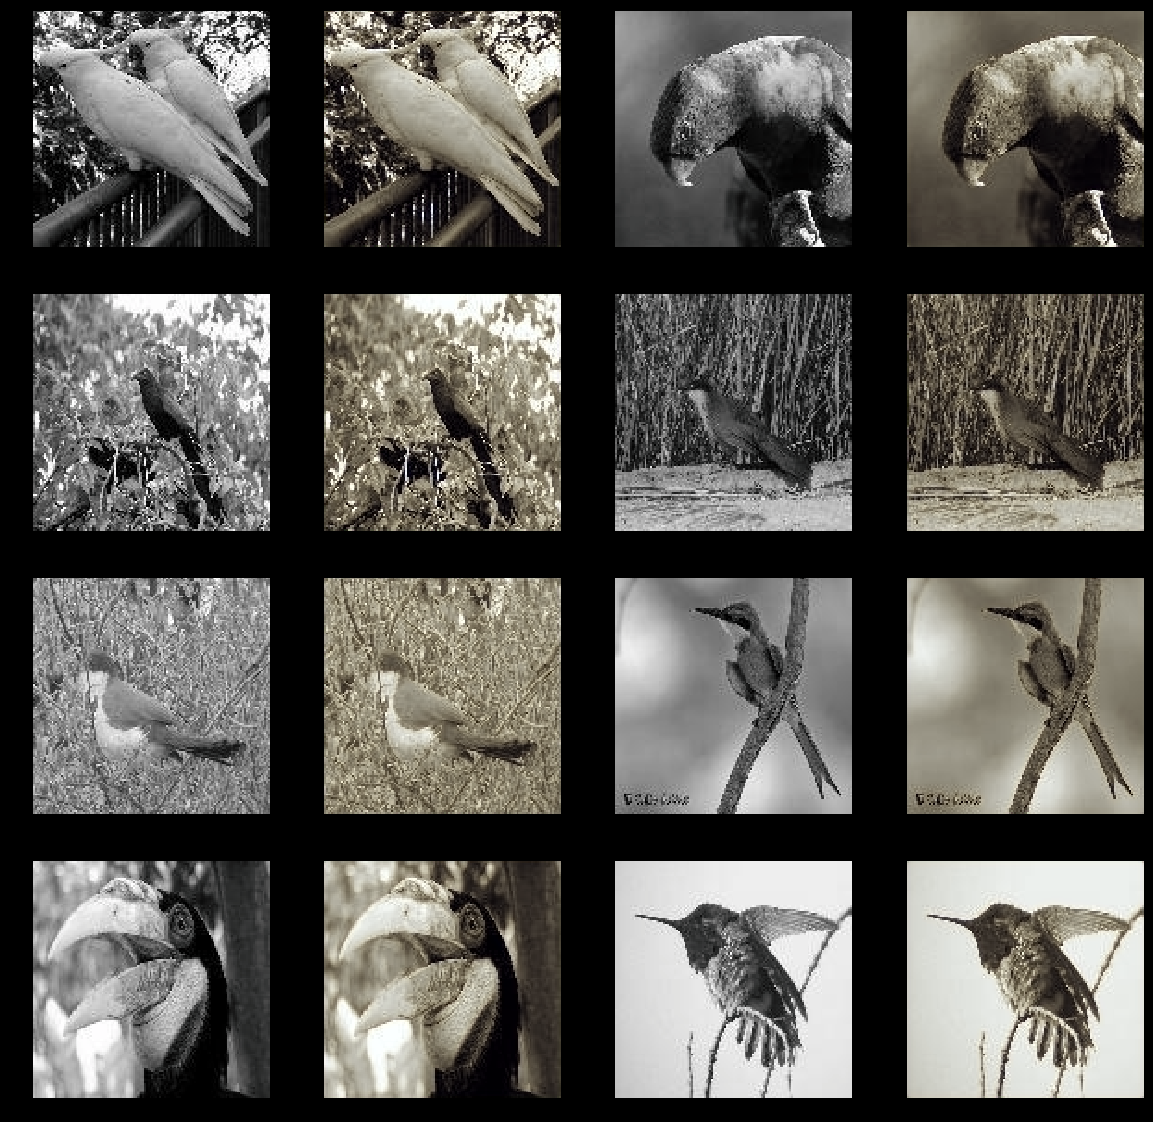

In [35]:
visualize(220,8)

In [22]:
train(lr,0) 
visualize(220,8)

epoch      trn_loss   val_loss   
    0      0.193198   0.157066  
    1      0.152763   0.144822  


TypeError: must be str, not int

epoch      trn_loss   val_loss   
    0      0.150255   0.146212  
    1      0.144581   0.142266  


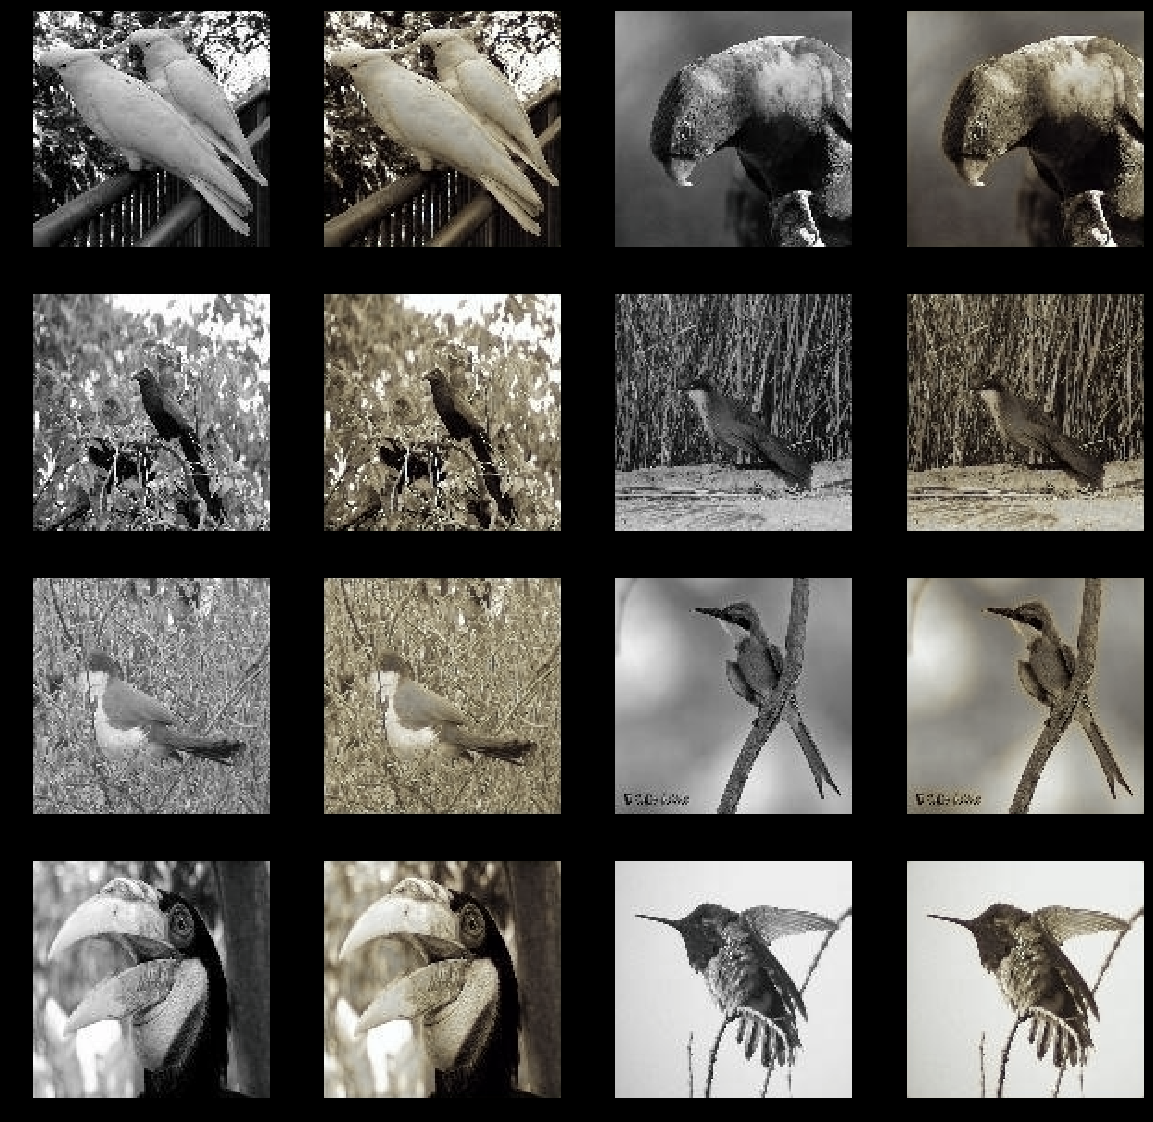

In [38]:
train(lr/2,1) 
visualize(220,8)

In [ ]:
train(lr/5,2) 
visualize(220,8)

 93%|█████████▎| 84/90 [01:32<00:06,  1.10s/it, loss=0.142]

In [ ]:
train(lr/10,1) 
visualize(220,8)